## Poisonous Mushroom Pipeline

In [3]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [4]:
#import dataset
dataset = pd.read_csv('../raw_data/secondary_data.csv', sep=";", low_memory=False)

In [5]:
df = dataset.copy()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,15.26,x,g,o,f,e,w,16.95,17.09,w,t,g,d,w
1,16.60,x,g,o,f,e,w,17.99,18.19,w,t,g,d,u
2,14.07,x,g,o,f,e,w,17.80,17.74,w,t,g,d,w
3,14.17,f,h,e,f,e,w,15.77,15.98,w,t,p,d,w
4,14.64,x,h,o,f,e,w,16.53,17.20,w,t,p,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,1.18,s,s,y,f,f,f,3.93,6.22,y,f,f,d,a
61065,1.27,f,s,y,f,f,f,3.18,5.43,y,f,f,d,a
61066,1.27,s,s,y,f,f,f,3.86,6.37,y,f,f,d,u
61067,1.24,f,s,y,f,f,f,3.56,5.44,y,f,f,d,u


In [7]:
drop_columns = ['gill-spacing', 'stem-root', 
                'stem-surface', 'veil-type', 
                'veil-color', 'spore-print-color',
                ]
df.drop(columns=drop_columns, inplace=True)

In [8]:
gender = {'p': 1,'e': 0}

df['class'] = [gender[item] for item in df['class']]

In [27]:
X = df.drop(columns='class')
y = df['class']

In [10]:
X.nunique()

cap-diameter            2571
cap-shape                  7
cap-surface               11
cap-color                 12
does-bruise-or-bleed       2
gill-attachment            7
gill-color                12
stem-height             2226
stem-width              4630
stem-color                13
has-ring                   2
ring-type                  8
habitat                    8
season                     4
dtype: int64

In [12]:
preprocessor = ColumnTransformer([
    ('num_encoder', MinMaxScaler(), make_column_selector(dtype_include="float64")),
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False), make_column_selector(dtype_include="object"))
])

preprocessor


ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12a8281c0>),
                                ('cat_encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12a8287c0>)])

In [13]:
pd.DataFrame(preprocessor.fit_transform(X)).head()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
0,0.240155,0.499705,0.164469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.261782,0.530366,0.175055,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.220949,0.524764,0.170725,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.222563,0.464917,0.153787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.230148,0.487323,0.165528,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
params = {
    "n_estimators": [1000],
    "max_depth": [30],
    "criterion": ["gini"]
}

In [15]:
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=1000,
                                                      criterion='gini', 
                                                      max_depth= 30,
                                                      random_state=123))
])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12a8281c0>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12a8287c0>)])),
                ('RandomForestClassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=1000,
                                        random_state=123))])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [32]:
#fitted_pipe = pipe.fit(X_train, y_train)

In [35]:
with open('../MushroomPrediction/rf_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [67]:
feature_names = model[:-1].get_feature_names_out()

mdi_importances = pd.Series(
    model[-1].feature_importances_  , index=feature_names
).sort_values()

In [88]:
mdi = mdi_importances[mdi_importances > 0.01]


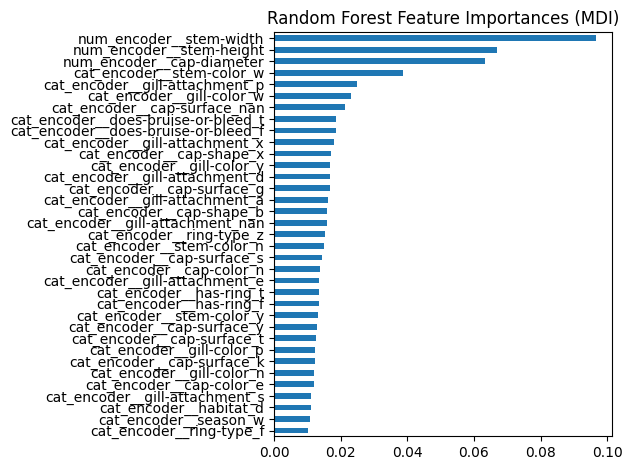

In [93]:
ax = mdi.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

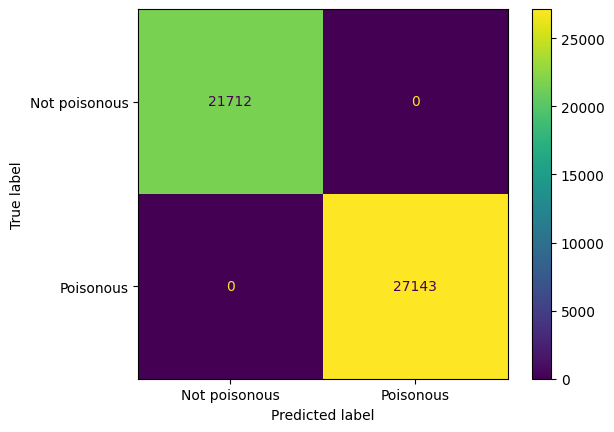

In [ ]:
ConfusionMatrixDisplay.from_estimator(fitted_pipe, X_train, y_train, display_labels=["Not poisonous", "Poisonous"]);

In [ ]:
acc_test = fitted_pipe.score(X_test, y_test)
print('accuracy:',round(acc_test,4)*100,'%')

accuracy: 99.98 %


In [ ]:
from sklearn.metrics import classification_report

print("Random Forest classification report:")
print(classification_report(y_test, fitted_pipe.predict(X_test)))


Random Forest classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5469
           1       1.00      1.00      1.00      6745

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



In [ ]:
predicted_test = fitted_pipe.predict(X_test)
matrix_test = confusion_matrix(y_test, predicted_test)

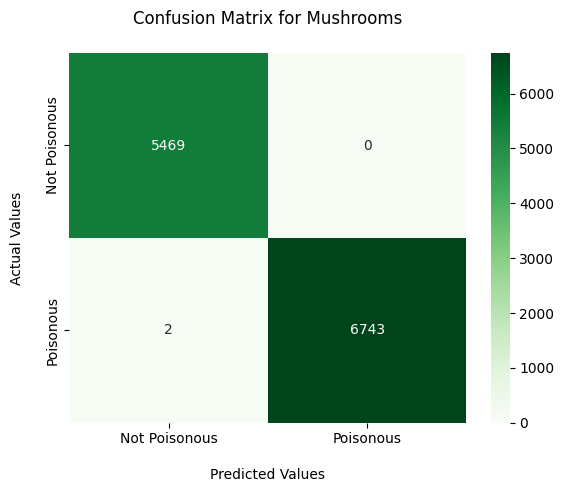

In [ ]:
ax = sns.heatmap(matrix_test, annot=True, cmap="Greens", fmt="g")

ax.set_title("Confusion Matrix for Mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not Poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not Poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

Inspecting the ROC curve for better recall

In [ ]:
probabilities = fitted_pipe.predict_proba(X_train)
probabilities_df = pd.DataFrame(probabilities)
probabilities_df

,0,1
0,0.002024,0.997976
1,0.000527,0.999473
2,0.942002,0.057998
3,0.012119,0.987881
4,0.000129,0.999871
...,...,...
48850,0.997879,0.002121
48851,0.990968,0.009032
48852,0.002785,0.997215
48853,0.002117,0.997883


In [ ]:
fpr, tpr, threshold = roc_curve(y_train, probabilities[:,1])

In [ ]:
roc_df = pd.DataFrame({"fpr":fpr,"tpr":tpr,"threshold":threshold})
roc_df

,fpr,tpr,threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.162989,1.000000
2,0.000000,0.163836,0.999997
3,0.000000,0.163983,0.999997
4,0.000000,0.164278,0.999997
...,...,...,...
6570,0.960068,1.000000,0.000005
6571,0.960667,1.000000,0.000005
6572,0.960759,1.000000,0.000004
6573,0.962924,1.000000,0.000002


In [ ]:

roc_df[roc_df["tpr"] == 1].nlargest(1, "threshold")


,fpr,tpr,threshold
3311,0.0,1.0,0.72569


In [ ]:
roc_df.loc[3311]

fpr          0.00000
tpr          1.00000
threshold    0.72569
Name: 3311, dtype: float64

In [ ]:
optimum_threshold_value = roc_df.threshold[3311]
optimum_threshold_value

0.7256902629909102

Setting the ROC Threshold for Random Froest Classifier

In [ ]:
new_predictions = (probabilities_df.loc[:,1] >= optimum_threshold_value).astype("int")
new_predictions

0        1
1        1
2        0
3        1
4        1
        ..
48850    0
48851    0
48852    1
48853    1
48854    0
Name: 1, Length: 48855, dtype: int64

In [ ]:
print(f"Probability: {probabilities_df.loc[3310, 1]}")
print(f"New Value: {new_predictions.loc[3310]}")

Probability: 0.9980795761295728
New Value: 1


In [ ]:
cf_matrix = confusion_matrix(y_train, new_predictions)

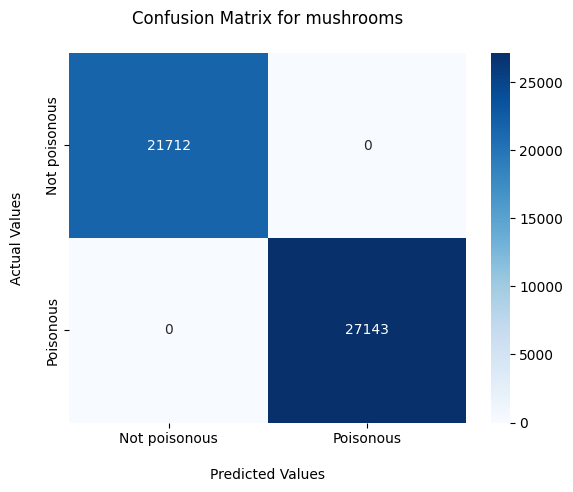

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g")

ax.set_title("Confusion Matrix for mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
probabilities_test_set = fitted_pipe.predict_proba(X_test)

# Use the probabilities and the threshold to make the predictions.
predicted_test = (probabilities_test_set[:,1] >= optimum_threshold_value).astype("int")

In [ ]:
matrix_test = confusion_matrix(y_test, predicted_test)

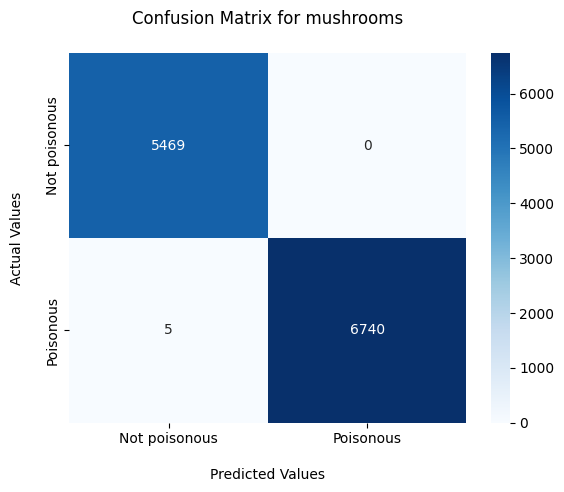

In [ ]:
ax = sns.heatmap(matrix_test, annot=True, cmap="Blues", fmt="g")

ax.set_title("Confusion Matrix for mushrooms\n");
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values\n");

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Not poisonous","Poisonous"])
ax.yaxis.set_ticklabels(["Not poisonous","Poisonous"])

## Display the visualization of the Confusion Matrix.
plt.show()

Weird ASF

In [3]:
with open('rf_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [4]:
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_encoder', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x105cc8b80>),
                                                 ('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x105cc8370>)])),
                ('RandomForestClassifier',
                 RandomForestClassifier(max_depth=30, n_estimators=1000,
                                        random_state=123))])